1. raw
2. ppg normalize(max4->1)
3. filter(cheby2) 
4. hampel filter(mark)
5. windowing
6. hampel window removal
7. remove anomaly abp & flat ppg/abp
8. ppg removal by skewness
9. ppg min-max normalization
10. abp min-max normalization

In [1]:
import heartpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,stats
import logging
from tqdm import tqdm,trange
import os
import glob
from sklearn.preprocessing import MinMaxScaler, scale, robust_scale,RobustScaler

In [52]:
def plot_hist(test,p=(0.5,99.5),lines=True):
    plt.figure()
    median = np.median(test)
    avg = np.average(test)
    std = np.std(test)
    p0 = np.percentile(test, p[0])
    p1 = np.percentile(test, p[1])
    plt.hist(test,bins=100)
    if lines:
        plt.axvline(median,c='orange')
        plt.axvline(avg,c='red')
        plt.axvline(p0,c='black')
        plt.axvline(p1,c='black')
    plt.title(f"median:{median:.3f}, average:{avg:.3f}, std:{std:.3f},\n min:{np.nanmin(test):.3f}, max:{np.nanmax(test):.3f},\n{p[0]:2.1f}%: {p0:.3f}, {p[1]:2.1f}%:{p1:.3f}")

In [128]:
def butterworth(sig,N=4,btype='bandpass',Wn=[0.5,8],fs=125):
    sos = signal.butter(N,Wn,btype,fs=fs,output='sos')
    return signal.sosfiltfilt(sos,sig)

def chebyshev2(x,order=4,rs=40,Wn=[0.5,15]):
    fs = 125
    filter = signal.cheby2(N=order, Wn=Wn,rs=rs,btype='bandpass',output='sos',fs=fs)
    return signal.sosfiltfilt(filter,x)

In [53]:
def load_signals_scaled(root_dir,phase='train',filter = None):
    filter_func = butterworth
    if phase == 'train':
        r = range(9)
    elif phase == 'validate':
        r = range(9,10)
    elif phase =='test':
        r = range(10,12)
    else:
        r = range(12)
    sig_all = []
    for i in tqdm(r):
        files = glob.glob(os.path.join(root_dir,f"p0000{i:02d}","0000000_*.npy"))
        sigs = []
        for f in files:
            a = np.load(f)
            if (a[1] > 1).any():
                a[1] = a[1]/4
            if np.count_nonzero(np.isnan(a)):
                print(np.count_nonzero(np.isnan(a)))
            if filter is not None:
                a[1] = filter_func(a[1],Wn=filter) 
            sigs.append(a)
        # sigs_cat = np.concatenate(sigs)
        sig_all.append(sigs)
        print(f[-24:-17])

    # print('all shape:', sig_all.shape)
    return sig_all

### 1-2. load raw data, normalize ppg

In [174]:
phase ='train'
DATA_ROOT = r"../data/raw/BPDataset/p00"
sig = load_signals_scaled(DATA_ROOT,phase)

 11%|█         | 1/9 [00:05<00:43,  5.47s/it]

p000000


 22%|██▏       | 2/9 [00:09<00:33,  4.79s/it]

p000001


 33%|███▎      | 3/9 [00:13<00:26,  4.47s/it]

p000002


 44%|████▍     | 4/9 [00:17<00:21,  4.22s/it]

p000003


 56%|█████▌    | 5/9 [00:21<00:16,  4.07s/it]

p000004


 67%|██████▋   | 6/9 [00:25<00:12,  4.18s/it]

p000005


 78%|███████▊  | 7/9 [00:31<00:09,  4.53s/it]

p000006


 89%|████████▉ | 8/9 [00:35<00:04,  4.45s/it]

p000007


100%|██████████| 9/9 [00:39<00:00,  4.41s/it]

p000008


### 3-4. filter ppg, hampel filter mark

In [131]:
def hampel(vals_orig, k=7, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    
    #Make copy so original not edited
    vals = vals_orig.copy()[(k-1)//2:-(k-1)//2]
    # print(vals.shape)
    #Hampel Filter
    L = 1.4826
    rolling_window = lambda x: np.lib.stride_tricks.sliding_window_view(x,k)
    rolling_median = np.median(rolling_window(vals_orig),axis=1)
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = MAD(rolling_window(vals_orig))
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    '''
    Perhaps a condition should be added here in the case that the threshold value
    is 0.0; maybe do not mark as outlier. MAD may be 0.0 without the original values
    being equal. See differences between MAD vs SDV.
    '''
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return vals,outlier_idx

In [132]:
def hampel_peaks(sig,k=11):
    wd,_=hp.process(sig,sample_rate=125.0)
    valid_peak_locs = np.array(wd['peaklist'])[wd['binary_peaklist']==1]
    a = wd['hr'][valid_peak_locs]
    if len(valid_peak_locs) < k:
        # print(f"### peaks:{len(valid_peak_locs)}, k:{k}, len:{len(sig)}")
        return None
    a.shape,len(wd['peaklist']),valid_peak_locs
    
    _,i = hampel(a,k=k)
    offset = (k//2)
    loc = valid_peak_locs[np.where(i)[0]+offset]
    return loc

In [175]:
len_sig = 1000
if phase == 'train':
    r = range(9)
elif phase == 'validate':
    r = range(1)
elif phase =='test':
    r = range(2)
else:
    r = range(12)
short_signals = []
outliers = []
for i in r:
    outliers_1 = []
    for j in trange(len_sig):
        # filter
        sig[i][j][1] = chebyshev2(sig[i][j][1])
        outlier_peaks = hampel_peaks(sig[i][j][1])
        outlier_valleys = hampel_peaks(-sig[i][j][1])
        if outlier_peaks is None or outlier_valleys is None:
            short_signals.append(i*1000+j)
            outliers_1.append(np.array([]))
            continue
        unique_outliers = np.unique(np.concatenate([outlier_peaks,outlier_valleys]))
        outliers_1.append(unique_outliers)
    lengths = [len(sublist) for sublist in outliers_1]
    print(" ".join(map(str, lengths)))
    outliers.append(outliers_1)



 12%|█▏        | 118/1000 [00:16<02:41,  5.46it/s]f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\interpolate\_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
 65%|██████▌   | 654/1000 [02:01<00:30, 11.44it/s]f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\interpolate\_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]


109 104 84 95 74 9 96 1 0 0 0 0 0 0 6 70 56 0 14 0 0 0 7 0 17 1 4 0 0 1 2 0 0 0 0 18 20 11 0 11 10 31 0 0 0 1 7 0 3 0 2 0 0 0 0 0 0 0 0 0 0 1 35 3 44 0 26 1 0 0 0 55 1 24 0 0 0 0 0 0 26 32 32 11 2 7 19 18 36 47 0 1 0 7 11 36 0 0 2 8 19 26 2 39 75 26 21 0 60 33 55 30 2 0 11 9 24 186 14 0 29 4 6 0 35 42 74 62 69 50 26 14 27 1 1 0 2 0 0 12 5 24 0 9 0 2 3 3 0 24 18 69 10 18 1 9 22 27 30 12 42 22 40 29 41 57 20 24 20 41 29 13 22 22 24 25 26 68 16 70 0 10 18 3 73 38 46 2 31 9 3 30 15 10 22 40 20 54 44 57 59 26 43 73 70 31 63 34 80 99 10 82 60 92 40 61 74 50 77 74 39 30 37 3 49 119 72 87 32 92 88 110 151 143 86 101 81 75 98 76 65 60 75 65 13 80 39 53 61 76 74 58 82 51 108 32 53 124 50 70 167 62 71 68 63 84 110 107 82 47 1 3 49 37 7 13 7 44 32 48 5 43 41 44 99 61 110 46 114 43 52 18 17 10 7 61 4 62 20 28 44 58 81 108 50 45 49 51 30 38 57 38 5 36 50 54 101 82 87 98 72 60 2 51 61 8 12 8 0 24 25 23 26 27 20 36 103 64 95 44 61 62 85 48 105 111 122 99 71 87 93 1 72 23 18 25 40 48 48 49 29 34 1 28 5

100%|██████████| 1000/1000 [02:19<00:00,  7.16it/s]


1 2 18 16 0 6 8 0 3 13 0 0 1 0 0 5 2 19 0 0 1 1 5 2 8 10 3 0 0 0 4 11 1 4 17 4 0 3 0 2 0 3 8 3 2 43 3 1 41 20 27 1 1 0 14 8 8 46 5 31 2 49 22 5 13 19 37 69 58 9 0 0 0 0 5 17 13 42 15 45 47 10 52 36 94 124 63 69 9 34 0 1 0 0 4 7 0 11 0 1 1 6 2 0 2 2 8 0 46 50 31 26 0 4 2 6 1 1 0 4 62 6 35 16 2 4 11 19 15 25 13 9 0 1 1 0 3 44 6 18 68 15 19 1 0 9 1 4 18 6 2 17 4 3 18 11 0 6 1 20 17 6 36 54 11 25 35 26 0 6 48 3 0 12 0 27 6 17 15 2 6 42 42 2 0 0 2 3 3 12 18 3 3 1 2 1 7 7 1 8 0 13 8 7 2 22 0 10 2 40 5 60 0 3 8 1 0 48 18 0 0 9 20 8 5 29 42 10 21 2 1 10 0 2 3 0 3 6 7 2 14 4 8 13 1 1 4 5 22 1 5 0 54 4 10 13 1 4 24 1 0 0 0 0 4 7 41 29 2 2 56 25 2 6 15 1 0 16 34 17 62 8 2 0 7 52 2 2 1 9 21 28 60 49 78 70 120 20 1 98 91 1 3 53 7 10 0 57 5 0 5 17 9 11 11 97 0 2 1 5 0 1 0 1 0 0 0 0 0 2 0 8 0 2 5 0 0 5 1 0 2 19 0 1 1 7 2 2 1 5 0 1 0 0 0 1 0 0 2 1 0 4 1 0 0 2 0 7 7 32 56 44 0 7 15 17 35 16 19 28 9 11 15 26 3 6 6 46 13 4 9 14 16 11 8 41 25 55 14 0 12 0 0 1 13 13 0 0 2 46 46 77 30 0 3 27 46 28 78 63 26 

100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]


10 4 5 3 2 8 2 3 8 5 13 0 8 14 17 4 14 0 0 8 8 9 0 8 5 6 6 6 8 0 52 6 0 5 1 0 1 0 1 21 5 4 2 4 0 27 21 21 20 89 79 52 2 43 47 75 92 1 9 0 0 0 25 13 0 10 9 5 3 10 7 33 3 26 7 1 10 13 35 20 38 4 79 9 2 25 0 2 15 32 23 11 3 1 2 8 2 9 0 0 0 0 0 1 11 19 31 17 0 6 2 16 2 1 21 45 3 1 10 8 7 3 2 24 14 4 10 5 2 28 0 0 6 0 2 3 0 15 2 25 1 58 36 60 39 64 37 23 13 23 0 5 11 17 13 11 3 7 7 15 18 11 52 3 8 13 58 21 37 15 15 43 0 1 0 2 1 0 2 0 2 0 3 10 6 4 13 6 4 102 102 60 30 1 14 4 4 0 6 0 1 6 5 25 16 0 0 3 0 6 2 0 6 21 0 0 19 50 25 9 6 11 14 8 8 15 6 29 53 39 11 8 30 12 13 77 0 26 118 33 21 77 45 22 28 55 10 33 80 59 39 106 31 89 4 34 8 6 22 57 15 16 2 0 0 1 4 33 3 13 2 1 3 5 5 0 7 2 27 21 22 0 13 14 1 7 1 0 0 15 19 7 5 16 21 33 28 34 41 18 22 13 16 3 13 11 31 42 39 25 13 32 0 2 4 63 49 47 42 45 44 33 25 18 24 11 4 9 1 10 11 10 22 17 17 80 40 0 80 44 25 101 28 31 54 15 75 6 60 10 43 19 12 0 0 4 2 60 18 29 3 0 16 61 8 1 5 30 1 0 2 3 3 29 36 44 50 19 27 0 0 0 22 4 55 19 15 17 1 6 13 22 27 1 3 7 26 7

100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s]


43 0 29 19 1 5 14 1 12 21 5 25 8 18 25 27 23 48 31 10 8 1 0 9 23 0 1 0 0 1 1 0 0 1 0 0 0 1 1 3 0 12 6 1 2 0 0 0 7 0 7 10 4 10 2 1 0 0 0 6 0 0 0 0 1 2 0 0 10 4 2 1 20 20 0 33 0 3 0 0 2 36 2 0 0 0 14 4 8 3 20 17 15 9 45 11 24 0 0 9 55 9 0 17 57 28 76 57 15 25 38 38 59 32 42 14 41 32 1 31 36 8 19 6 14 8 0 61 54 58 37 55 31 63 38 10 81 12 30 86 13 0 2 103 23 40 20 13 21 3 0 9 1 0 1 20 45 9 1 0 0 0 13 4 2 2 8 0 1 17 19 49 13 1 0 31 35 0 0 20 64 90 25 12 46 17 37 34 82 0 44 72 44 67 34 18 3 18 37 42 1 37 48 0 9 21 19 3 0 1 3 3 18 1 7 4 1 1 0 2 16 0 0 2 0 10 5 1 0 1 2 1 34 34 13 29 41 8 7 1 21 0 30 0 30 21 21 42 64 36 33 20 47 14 19 24 34 27 32 46 3 1 0 17 0 36 0 28 0 3 29 1 0 0 22 9 0 47 0 4 1 16 3 1 2 6 0 12 0 0 8 10 41 45 1 20 15 11 0 0 14 0 2 0 0 2 5 0 5 0 0 0 9 31 5 0 39 14 12 0 15 15 3 16 2 5 2 5 33 0 0 5 63 57 9 43 12 14 24 14 30 21 93 20 8 0 2 0 22 6 10 24 50 1 45 3 3 5 26 13 8 16 19 39 13 4 1 9 75 29 52 39 68 3 0 0 7 1 10 3 21 12 5 21 91 13 25 31 30 9 12 19 63 1 19 26 24 2 67 2 0 0 0

100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


7 3 0 8 14 10 8 0 1 2 0 7 15 2 0 0 15 1 17 4 35 11 13 22 28 21 10 30 7 2 2 4 1 15 5 17 54 25 7 25 1 0 13 5 4 6 19 24 5 14 8 18 0 31 7 13 42 2 61 15 10 22 53 34 27 5 0 52 56 4 57 3 17 43 31 32 74 10 2 10 0 12 31 0 0 9 4 3 6 0 0 5 0 13 30 0 26 29 1 9 6 24 15 21 2 10 7 2 13 0 0 18 32 15 38 0 35 9 25 0 17 10 35 4 26 18 26 6 4 10 1 12 9 30 0 1 0 1 1 30 26 5 0 10 9 8 0 0 1 10 3 10 29 14 42 16 6 38 2 1 13 20 0 6 66 3 8 4 18 21 13 13 6 8 21 18 21 9 16 74 15 19 33 53 69 30 12 0 89 0 3 1 25 5 3 1 24 24 53 110 11 20 5 19 22 19 14 1 6 13 1 6 9 20 20 12 3 1 8 1 2 29 10 36 7 3 10 5 21 0 2 9 21 12 9 9 30 5 6 18 23 38 16 61 6 1 13 0 2 8 3 7 29 2 1 6 29 50 6 32 62 2 16 55 34 10 16 14 2 15 2 1 2 8 1 1 0 20 2 5 10 12 1 22 16 2 52 24 18 9 15 28 23 19 47 49 34 44 6 0 43 22 96 0 31 0 28 3 4 0 5 16 29 10 23 8 10 0 5 8 0 0 1 0 0 22 31 5 8 22 24 21 15 4 6 0 33 65 78 110 72 47 23 30 18 26 49 20 18 22 53 3 20 56 32 30 29 0 0 1 0 1 0 1 0 24 9 0 0 0 3 4 0 15 28 32 26 30 7 44 17 20 34 13 35 15 26 68 15 37 71 44 36 

100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]


13 1 63 0 44 51 2 1 0 0 0 9 38 31 51 0 5 68 56 13 103 132 89 146 99 100 168 108 44 128 8 37 0 34 26 78 53 12 71 4 84 86 57 40 67 58 53 56 1 62 148 3 1 75 197 34 22 8 27 48 83 24 8 22 12 12 16 8 3 13 0 0 7 2 3 28 49 1 19 25 1 0 46 26 34 0 27 23 7 27 10 19 29 2 4 29 41 49 66 139 30 116 0 123 257 170 129 2 19 4 3 3 3 2 0 1 12 19 14 1 5 5 38 0 9 0 5 12 12 28 4 43 18 31 1 7 4 3 6 2 0 0 2 2 2 6 3 58 1 0 8 45 10 0 16 0 39 11 0 7 5 15 0 17 0 0 0 4 2 1 0 0 3 18 6 24 20 7 28 0 18 6 16 4 1 10 5 35 35 33 24 61 23 5 1 27 17 12 9 2 12 99 2 35 28 2 34 34 1 8 24 38 38 12 13 21 41 83 48 75 0 12 21 5 12 18 18 32 3 34 9 19 1 29 41 2 1 0 5 11 9 16 4 19 16 1 3 4 3 0 16 35 4 57 64 38 58 61 34 50 109 8 0 2 3 16 15 19 4 8 1 28 15 46 16 63 93 30 30 22 146 49 23 29 26 74 56 84 15 65 50 3 29 25 68 100 45 40 65 40 50 5 1 5 3 1 0 0 24 0 31 4 45 26 55 64 42 19 54 36 36 40 49 1 106 71 62 92 66 40 61 25 0 9 41 31 13 43 27 4 3 16 46 8 52 71 28 18 29 3 35 14 3 21 4 56 2 35 35 11 29 8 8 2 12 7 0 1 17 23 0 23 1 1 20 20 1

100%|██████████| 1000/1000 [01:10<00:00, 14.19it/s]


0 15 0 4 0 1 7 2 0 0 7 0 0 0 2 3 0 11 0 1 0 4 2 0 9 32 5 0 5 17 2 3 24 4 16 0 6 1 3 0 1 23 0 0 30 2 1 35 7 2 2 18 7 0 3 12 17 0 11 38 0 4 0 0 9 0 12 0 2 0 10 31 0 3 3 0 1 0 2 24 64 6 10 53 7 0 2 4 3 0 0 12 1 0 5 1 10 0 0 1 0 0 12 3 0 2 0 0 0 0 23 2 0 2 0 4 12 0 0 0 6 13 12 0 1 4 22 0 1 0 14 0 5 1 2 12 6 0 0 0 0 0 0 0 0 0 0 1 1 2 1 2 0 0 3 3 0 1 24 31 38 2 0 24 20 2 5 26 3 15 3 12 4 21 24 2 10 5 0 2 13 15 3 3 0 0 3 5 1 0 1 3 13 4 0 4 5 10 1 5 0 0 8 3 2 0 4 1 0 3 6 0 0 5 4 3 1 9 0 2 2 0 2 1 1 0 17 0 0 7 0 1 0 5 3 0 1 1 0 0 2 1 4 10 16 12 0 6 19 12 21 7 2 0 4 0 0 1 0 4 50 1 9 2 5 0 2 6 0 3 2 5 1 0 11 0 0 1 0 0 0 2 0 3 2 4 3 2 3 0 0 0 0 0 0 1 12 1 0 0 0 7 26 0 3 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 4 0 0 4 0 0 0 0 0 0 2 0 0 1 25 1 3 0 0 1 0 1 0 0 3 1 0 1 0 0 0 0 0 0 0 0 2 2 7 0 0 0 4 7 4 1 10 15 6 8 11 0 8 0 1 29 2 12 2 0 7 1 1 4 1 1 2 9 0 0 1 0 1 0 1 10 1 31 2 1 30 0 9 0 5 1 14 17 25 1 0 1 0 0 0 43 25 4 27 24 10 0 66 2 1 4 0 13 4 10 1 1 5 0 66 39 1 28 22 29 0 33 15 0 8 0 0 0 4 8 30 23 

 67%|██████▋   | 667/1000 [01:17<00:10, 31.04it/s]f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\ma\core.py:5334: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 1000/1000 [01:52<00:00,  8.91it/s]


0 5 40 10 15 41 32 10 31 50 31 52 26 8 2 13 28 63 26 34 12 35 27 16 4 1 10 5 0 6 2 1 5 5 4 9 6 9 8 11 2 19 14 23 7 28 10 9 10 28 3 61 43 14 9 9 18 0 4 5 36 7 2 9 48 14 1 15 55 4 21 7 30 28 18 49 0 37 10 24 8 6 12 61 53 26 2 30 58 54 3 3 0 6 3 1 0 7 9 9 0 0 18 8 1 5 2 14 4 7 0 6 82 0 102 51 26 20 0 31 0 0 4 88 14 19 16 15 5 11 5 31 10 6 17 0 0 10 0 11 13 6 14 12 17 11 13 27 5 8 20 0 0 0 1 8 3 26 1 1 3 22 32 8 36 27 50 32 94 111 31 99 1 32 24 96 53 111 30 92 65 36 4 35 116 50 67 53 45 47 23 42 1 0 0 45 99 22 36 54 40 73 74 87 19 33 13 0 20 67 63 13 33 24 46 31 77 87 76 20 19 19 6 13 0 0 28 36 53 4 38 12 48 27 1 25 0 31 0 6 15 71 68 1 13 16 3 1 9 25 22 24 3 7 10 11 13 18 28 7 19 45 20 5 0 4 11 20 0 0 5 0 1 0 0 0 2 11 36 46 74 33 89 27 56 44 114 21 106 35 43 47 12 40 95 0 0 2 2 0 1 2 15 1 1 27 27 63 63 12 37 1 9 9 16 3 24 0 25 17 17 33 7 4 15 40 112 0 46 10 4 2 4 8 36 95 78 128 20 0 17 189 45 3 3 15 10 47 50 44 39 38 2 0 11 0 8 3 0 7 0 1 0 12 3 3 0 7 0 0 8 4 5 2 15 0 0 1 0 0 7 15 0 21 3 9 

100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s]

9 74 49 14 10 51 35 40 62 13 37 0 0 100 157 0 60 42 56 3 82 5 43 37 44 51 34 32 83 22 0 11 2 1 11 3 81 157 8 26 18 82 42 45 65 0 1 12 11 14 4 2 9 10 25 0 0 0 3 51 51 13 0 0 6 0 3 11 4 27 1 12 11 8 1 0 0 2 0 0 9 16 54 28 76 158 15 15 10 1 9 9 10 8 0 0 8 11 3 31 27 29 29 82 13 23 23 73 11 31 33 0 35 53 47 31 37 8 25 8 46 24 27 2 3 0 14 24 0 5 0 0 3 15 2 17 72 26 26 17 18 0 8 0 1 14 2 7 0 0 0 7 46 8 12 22 12 20 10 3 13 19 13 0 5 0 8 5 2 0 31 0 1 3 1 3 2 0 0 0 4 5 0 7 6 16 15 10 10 2 5 7 3 1 3 1 0 5 0 4 1 5 67 67 3 45 47 10 38 0 0 0 3 5 0 0 0 0 1 0 3 14 14 70 46 55 19 0 0 0 0 9 0 0 0 1 21 3 0 0 6 1 1 2 1 15 42 50 7 6 0 0 2 3 10 2 4 22 0 16 0 6 9 2 1 7 6 23 49 40 40 27 7 4 5 13 0 16 35 2 46 11 8 31 14 16 22 11 3 26 15 46 24 12 4 12 39 38 15 39 73 51 16 5 11 85 9 52 34 10 25 79 24 5 27 9 26 11 3 7 70 33 57 8 35 67 12 81 10 86 49 34 17 10 28 18 36 9 10 32 4 16 36 32 4 27 33 50 18 19 0 16 18 7 11 2 4 1 5 5 0 5 6 4 0 2 16 3 0 12 4 4 1 3 0 7 8 30 21 12 28 49 14 33 19 0 2 21 6 61 29 51 7 6 9 9 13

### 5-6. window, hampel filter removal

In [176]:
px = 512
sigs = []
if phase == 'train':
    r = range(9)
elif phase == 'validate':
    r = range(1)
elif phase =='test':
    r = range(2)
else:
    r = range(12)
for i in r:
    s = []
    for j in trange(1000):
        if i*1000+j in short_signals:
            continue
        target = sig[i][j]
        # print(target.shape)
        r = range(0,target.shape[1]-px,px)
        mask = np.full_like(np.array(r),True)
        for k in outliers[i][j]:
            # print(k)
            if k >=target.shape[1]-px:
                continue
            mask[k//px] = False
        for k,e in enumerate(r):
            if mask[k]:
                s.append(target[:,e:e+px])
    cat = np.stack(s,axis=0)
    sigs.append(cat)
    print(cat.shape)
sigs =np.concatenate(sigs,axis=0)
print(sigs.shape)

100%|██████████| 1000/1000 [00:00<00:00, 27776.85it/s]


(48858, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 26316.05it/s]


(46409, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 33333.10it/s]


(36285, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 20407.95it/s]


(50387, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 16128.90it/s]


(54140, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 16129.21it/s]


(52351, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 35714.14it/s]


(24777, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 35714.44it/s]


(39025, 2, 512)


100%|██████████| 1000/1000 [00:00<00:00, 22222.77it/s]


(51689, 2, 512)
(403921, 2, 512)


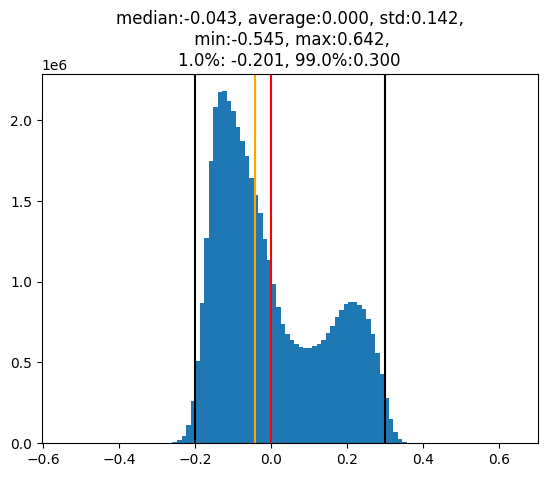

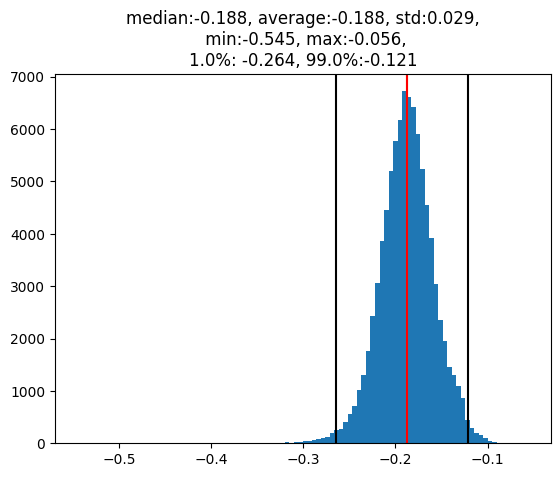

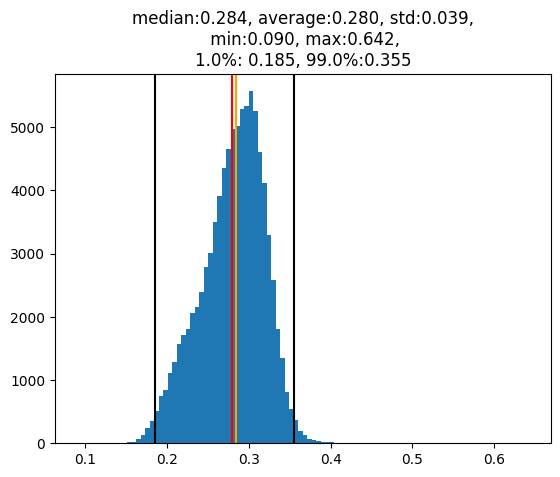

In [167]:
min_sig = np.nanmin(sigs[:,1],axis=1)
max_sig= np.nanmax(sigs[:,1],axis=1)
plot_hist(sigs[:,1].flatten(),(1,99))
plot_hist(min_sig,(1,99))
plot_hist(max_sig,(1,99))

### 7. remove anomaly abp & flat ppg/abp

In [168]:
old_sigs_shape = sigs.shape
dbp = np.nanmin(sigs[:,0],axis=1)
sbp = np.nanmax(sigs[:,0],axis=1)
dbp_final = np.where(dbp>105)[0]
sbp_final = np.where((sbp < 85) | (sbp >180))[0]
mask1 = np.where(((sbp>148) & (sbp<148.1)) | ((sbp>185.0) & (sbp<185.21)) |  ((sbp>173) & (sbp<173.1)) | ((sbp>119.0) & (sbp<119.1)))[0]

mask_flat =  np.full(len(sbp), True)
mask_flat[mask1] = False
mask_dbp = np.full(len(sbp), True)
mask_dbp[dbp_final] = False

mask_sbp = np.full(len(sbp), True)
mask_sbp[sbp_final] = False
mask_abp = mask_dbp & mask_sbp & mask_flat
sigs = sigs[mask_abp]
print("dbp removal:",len(dbp_final),", sbp removal:",len(sbp_final),", flat removal",len(mask1), ", final shape:",old_sigs_shape,"->",sigs.shape)

dbp removal: 700 , sbp removal: 2402 , flat removal 904 , final shape: (90729, 2, 512) -> (87482, 2, 512)


### 8. ppg removal by Skewness

In [169]:
old_sigs_shape = sigs.shape
Ssqi = stats.skew(sigs[:,1],axis=1)
sigs = sigs[Ssqi>0]
print(old_sigs_shape,"->",sigs.shape)

(87482, 2, 512) -> (87116, 2, 512)


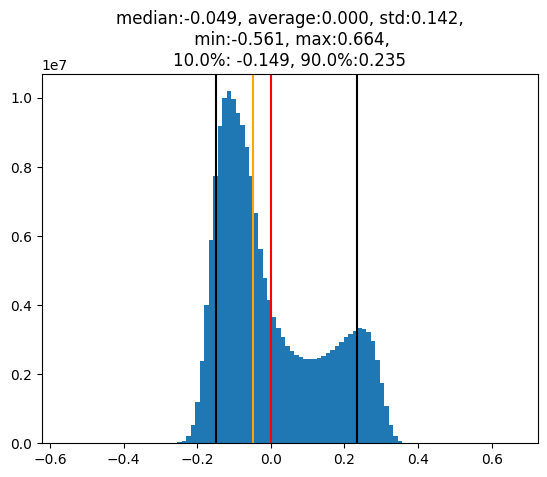

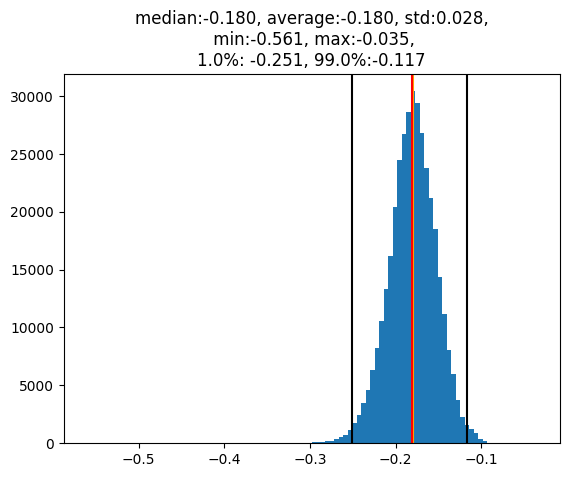

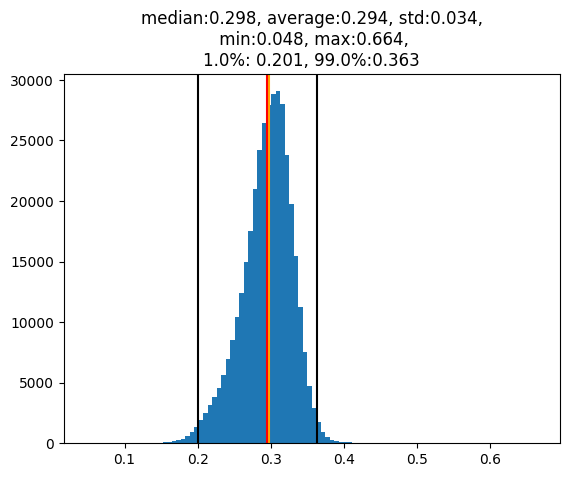

In [137]:
min_sig = np.nanmin(sigs[:,1],axis=1)
max_sig= np.nanmax(sigs[:,1],axis=1)
plot_hist(sigs[:,1].flatten(),(10,90))
plot_hist(min_sig,(1,99))
plot_hist(max_sig,(1,99))

### ex. ppg outlier removal

In [170]:

min_sig = np.nanmin(sigs[:,1],axis=1)
max_sig= np.nanmax(sigs[:,1],axis=1)
print(sigs.shape)
mask = np.where(~((min_sig <= np.percentile(min_sig, 1)) | (min_sig >= np.percentile(min_sig, 99)) | (max_sig <= np.percentile(max_sig, 1)) | (max_sig >= np.percentile(max_sig, 99))))[0]
sigs = sigs[mask]
print(sigs2.shape)

(87116, 2, 512)
(83727, 2, 512)


### 9. ppg normalization(robust scaler)

In [73]:
sigs[:,1] = scaler.inverse_transform(sigs[:,1].reshape(-1,1)).reshape(-1,256)

In [107]:
sigs[:,1] -= (0.5-scaler.center_)/scaler.scale_

In [171]:
if phase == 'train':
    # scaler = RobustScaler(quantile_range=(1.0,99.0))
    scaler = MinMaxScaler()
    sigs[:,1] = scaler.fit_transform(sigs[:,1].reshape(-1,1)).reshape(-1,px)
else:
    sigs[:,1] = scaler.transform(sigs[:,1].reshape(-1,1)).reshape(-1,px)
# sigs[:,1] += (0.5-scaler.center_)/scaler.scale_


In [147]:
scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_,scaler.data_range_

(array([0.40907135]),
 array([1.62808886]),
 array([-0.25125861]),
 array([0.36295847]),
 array([0.61421709]))

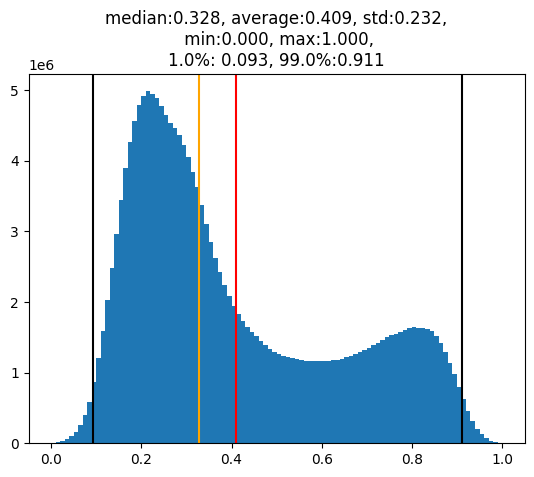

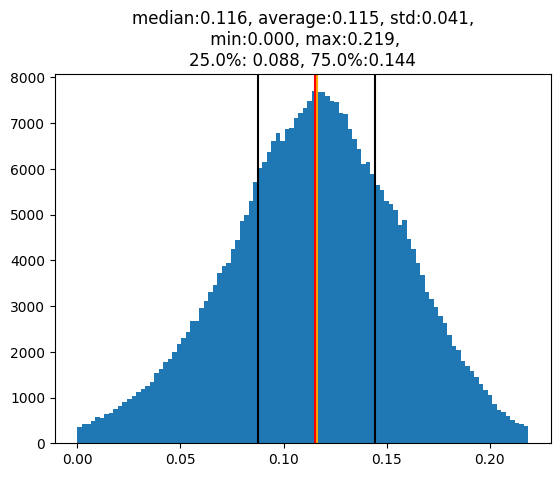

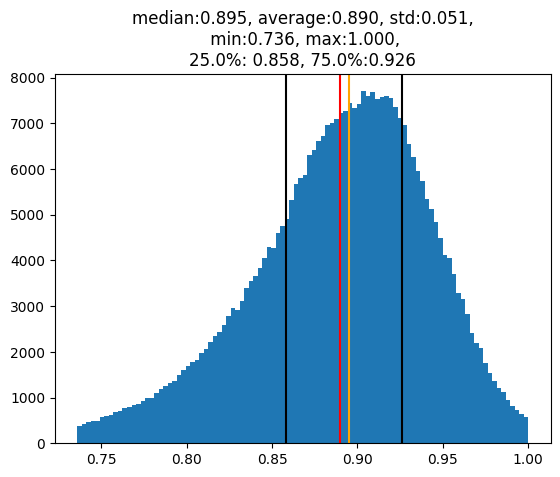

In [148]:
min_sig = np.nanmin(sigs[:,1],axis=1)
max_sig= np.nanmax(sigs[:,1],axis=1)
plot_hist(sigs[:,1].flatten(),(1,99))
plot_hist(min_sig,(25,75))
plot_hist(max_sig,(25,75))

(array([-0.04669225]), array([0.51115991]))

In [106]:
scaler.center_,scaler.scale_

(array([0.39076246]), array([0.51735093]))

### 10. abp min-max normalization

In [77]:
sigs.shape

(800388, 2, 256)

In [172]:
if phase == 'train':
    scaler_abp = MinMaxScaler()
    sigs[:,0] = scaler_abp.fit_transform(sigs[:,0].reshape(-1,1)).reshape(-1,px)
else:
    sigs[:,0] = scaler_abp.transform(sigs[:,0].reshape(-1,1)).reshape(-1,px)

(array([-0.38461538]),
 array([0.00769231]),
 array([50.]),
 array([180.]),
 array([130.]))

In [151]:
scaler_abp.min_,scaler_abp.scale_,scaler_abp.data_min_,scaler_abp.data_max_,scaler_abp.data_range_

(array([-0.38461538]),
 array([0.00769231]),
 array([50.]),
 array([180.]),
 array([130.]))

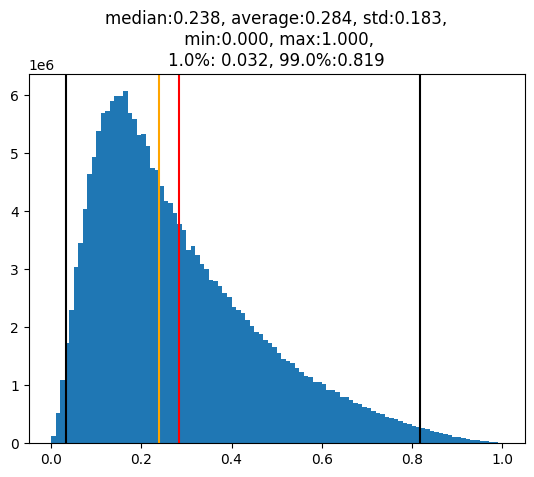

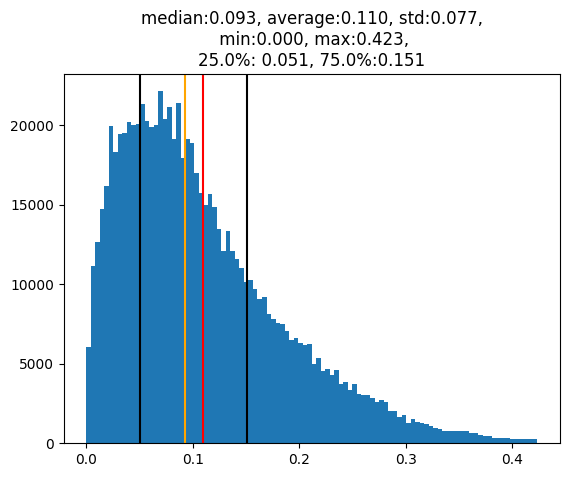

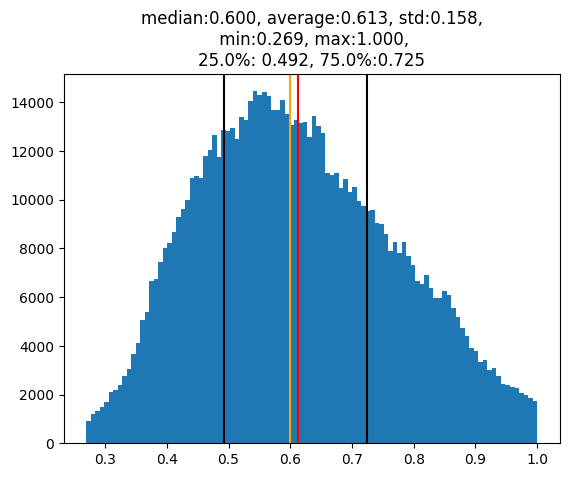

In [85]:
min_sig = np.nanmin(sigs[:,0],axis=1)
max_sig= np.nanmax(sigs[:,0],axis=1)
plot_hist(sigs[:,0].flatten(),(1,99))
plot_hist(min_sig,(25,75))
plot_hist(max_sig,(25,75))

In [173]:
dirname='0124_filt_512'
os.makedirs(os.path.join(r"..\data\processed\BP_npy",dirname,"p00"),exist_ok=True)
assert not os.path.isfile(os.path.join(r"..\data\processed\BP_npy",dirname,"p00",phase+".npy"))
np.save(os.path.join(r"..\data\processed\BP_npy",dirname,"p00",phase+".npy"),sigs.transpose(0,2,1))
import pickle
with open(os.path.join(r"..\data\processed\BP_npy",dirname,"p00",phase+"_outliers.p"), mode="wb") as f:
    pickle.dump(outliers, f)

In [154]:
sigs.shape

(356788, 2, 512)

### garbage

In [86]:
test = np.load(r"..\data\processed\BP_npy\1219\p00\p000000.npy")
test.shape

(62016, 512, 2)

In [50]:
for i,e in enumerate(sig[0]):
    print(i,e.shape)

0 (2, 61000)
1 (2, 61000)
2 (2, 50000)
3 (2, 70000)
4 (2, 69000)
5 (2, 21000)
6 (2, 71000)
7 (2, 4000)
8 (2, 2000)
9 (2, 1000)
10 (2, 1000)
11 (2, 2000)
12 (2, 1000)
13 (2, 1000)
14 (2, 28000)
15 (2, 67000)
16 (2, 64000)
17 (2, 20000)
18 (2, 57000)
19 (2, 2000)
20 (2, 2000)
21 (2, 1000)
22 (2, 4000)
23 (2, 5000)
24 (2, 72000)
25 (2, 4000)
26 (2, 4000)
27 (2, 5000)
28 (2, 6000)
29 (2, 6000)
30 (2, 5000)
31 (2, 3000)
32 (2, 5000)
33 (2, 6000)
34 (2, 6000)
35 (2, 74000)
36 (2, 73000)
37 (2, 48000)
38 (2, 16000)
39 (2, 60000)
40 (2, 72000)
41 (2, 73000)
42 (2, 11000)
43 (2, 2000)
44 (2, 6000)
45 (2, 7000)
46 (2, 68000)
47 (2, 1000)
48 (2, 4000)
49 (2, 1000)
50 (2, 11000)
51 (2, 1000)
52 (2, 4000)
53 (2, 2000)
54 (2, 1000)
55 (2, 3000)
56 (2, 1000)
57 (2, 4000)
58 (2, 2000)
59 (2, 1000)
60 (2, 1000)
61 (2, 3000)
62 (2, 11000)
63 (2, 5000)
64 (2, 37000)
65 (2, 1000)
66 (2, 67000)
67 (2, 74000)
68 (2, 4000)
69 (2, 2000)
70 (2, 7000)
71 (2, 12000)
72 (2, 2000)
73 (2, 72000)
74 (2, 4000)
75 (2,

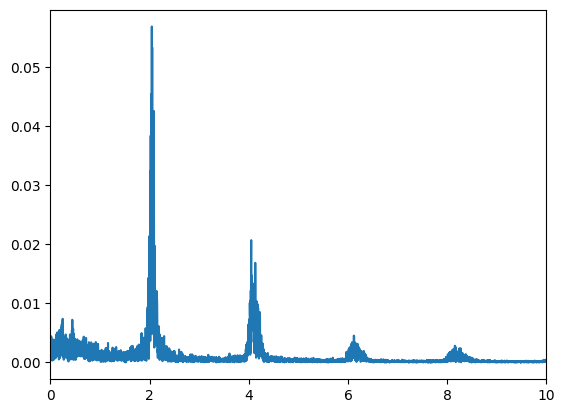

In [27]:
N=61000
f_s =125
dt=1/f_s
freq = np.fft.fftfreq(N, d=dt) # 周波数を割り当てる（※後述）
y_fft = np.fft.fft(sig[0][0][1]) # 離散フーリエ変換
Amp = abs(y_fft/(N/2)) # 音の大きさ（振幅の大きさ）
plt.plot(freq[1:int(N/2)], Amp[1:int(N/2)]) # A-f グラフのプロット
# plt.xscale("log") # 横軸を対数軸にセット
plt.xlim(0,10)
plt.show()

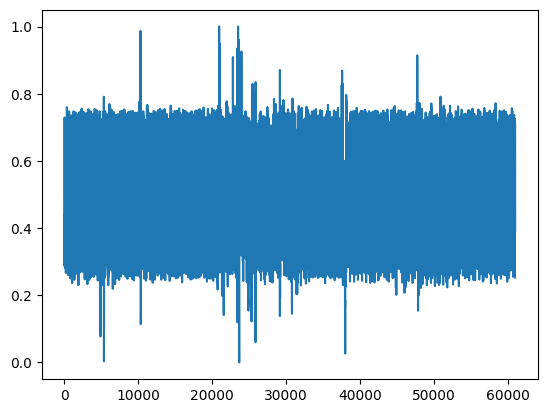

In [28]:
plt.plot(sig[0][0][1])

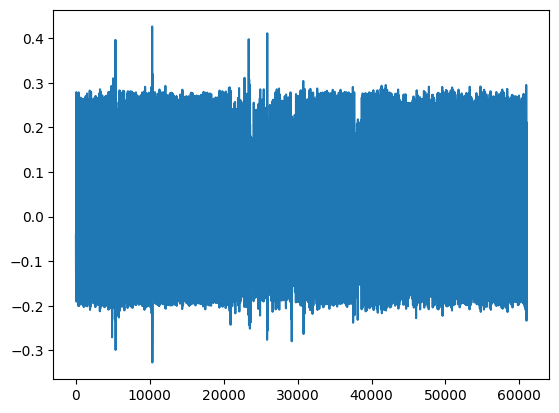

In [104]:
sig2 =chebyshev2(sig[0][0][1])
plt.plot(sig2)

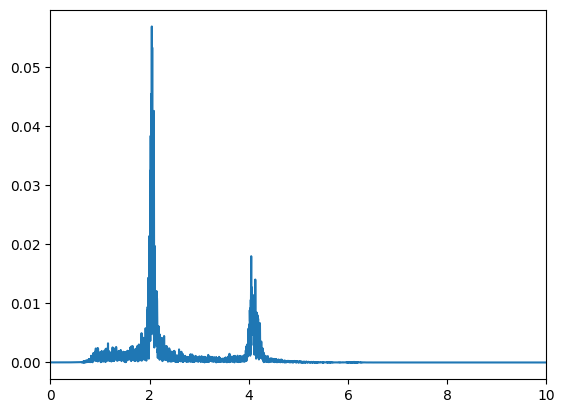

In [30]:
y_fft = np.fft.fft(sig2) # 離散フーリエ変換
Amp = abs(y_fft/(N/2)) # 音の大きさ（振幅の大きさ）
plt.plot(freq[1:int(N/2)], Amp[1:int(N/2)]) # A-f グラフのプロット
# plt.xscale("log") # 横軸を対数軸にセット
plt.xlim(0,10)
plt.show()

In [32]:
def rand_plot(sig,index=None):
    plt.figure()
    if index is None:
        i = np.random.randint(len(sig))
        target = sig[i]
    else:
        i = index[np.random.randint(len(index))]
        target = sig[i]
    print("#",i,target.shape)
    plt.plot(target)

(188,) (61000,)


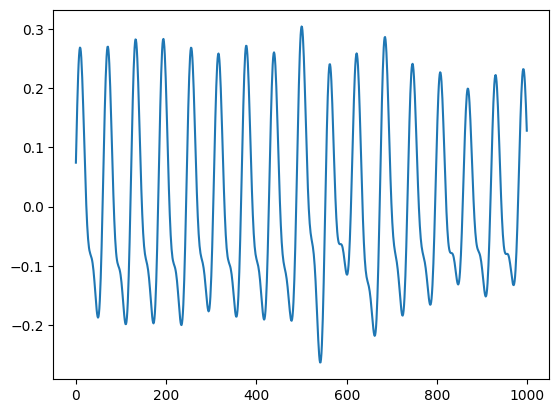

In [49]:
a = np.where((sig2>0.3) | (sig2<-0.23))[0]
print(a.shape,sig2.shape)
i = np.random.randint(len(a))
plt.plot(sig2[a[i]-500:a[i]+500])

In [53]:
wd,m=hp.process(sig2,sample_rate=125.0)
wd,m

({'hr': array([0.21035317, 0.206864  , 0.20365878, ..., 0.24301412, 0.23166511,
         0.22230846]),
  'sample_rate': 125.0,
  'peaklist': [47,
   109,
   171,
   233,
   294,
   356,
   418,
   479,
   539,
   600,
   661,
   721,
   782,
   841,
   901,
   962,
   1022,
   1083,
   1142,
   1203,
   1264,
   1324,
   1385,
   1445,
   1506,
   1567,
   1628,
   1689,
   1749,
   1810,
   1870,
   1932,
   1992,
   2053,
   2115,
   2176,
   2236,
   2297,
   2358,
   2419,
   2480,
   2540,
   2600,
   2661,
   2721,
   2782,
   2841,
   2901,
   2962,
   3022,
   3082,
   3142,
   3202,
   3263,
   3323,
   3384,
   3445,
   3506,
   3567,
   3629,
   3690,
   3751,
   3812,
   3874,
   3935,
   3996,
   4056,
   4118,
   4179,
   4240,
   4300,
   4361,
   4422,
   4483,
   4545,
   4605,
   4666,
   4728,
   4790,
   4853,
   4915,
   4976,
   5053,
   5113,
   5173,
   5233,
   5294,
   5352,
   5414,
   5474,
   5535,
   5597,
   5659,
   5720,
   5782,
   5844,
   5906,
   59

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


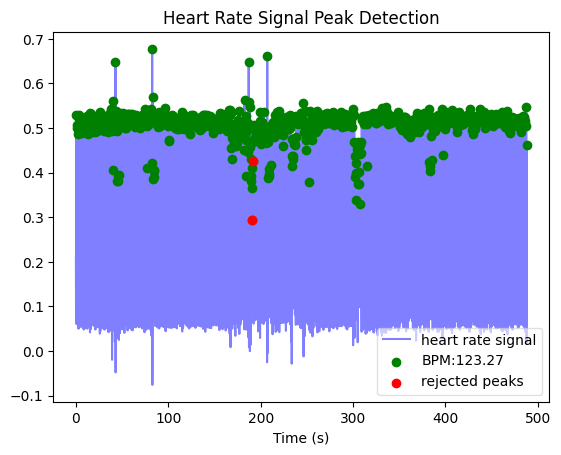

In [54]:
hp.plotter(wd,m)

In [55]:
m.keys()

dict_keys(['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate'])

In [56]:
wd.keys()

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq'])

[47, 109, 171, 233, 294, 356, 418, 479, 539, 600, 661, 721, 782, 841, 901, 962, 1022, 1083, 1142, 1203, 1264, 1324, 1385, 1445, 1506, 1567, 1628, 1689, 1749, 1810, 1870, 1932, 1992, 2053, 2115, 2176, 2236, 2297, 2358, 2419, 2480, 2540, 2600, 2661, 2721, 2782, 2841, 2901, 2962, 3022, 3082, 3142, 3202, 3263, 3323, 3384, 3445, 3506, 3567, 3629, 3690, 3751, 3812, 3874, 3935, 3996, 4056, 4118, 4179, 4240, 4300, 4361, 4422, 4483, 4545, 4605, 4666, 4728, 4790, 4853, 4915, 4976, 5053, 5113, 5173, 5233, 5294, 5352, 5414, 5474, 5535, 5597, 5659, 5720, 5782, 5844, 5906, 5969, 6029, 6090, 6152, 6214, 6275, 6336, 6398, 6459, 6521, 6582, 6643, 6706, 6768, 6830, 6891, 6952, 7014, 7076, 7137, 7198, 7259, 7321, 7382, 7444, 7505, 7567, 7629, 7692, 7753, 7815, 7878, 7940, 8002, 8064, 8127, 8189, 8252, 8313, 8374, 8437, 8498, 8560, 8621, 8683, 8744, 8806, 8867, 8928, 8990, 9052, 9114, 9175, 9236, 9299, 9361, 9424, 9485, 9547, 9609, 9648, 9706, 9768, 9830, 9893, 9954, 10015, 10077, 10139, 10201, 10261, 103

((1000,),
 1002,
 array([   47,   109,   171,   233,   294,   356,   418,   479,   539,
          600,   661,   721,   782,   841,   901,   962,  1022,  1083,
         1142,  1203,  1264,  1324,  1385,  1445,  1506,  1567,  1628,
         1689,  1749,  1810,  1870,  1932,  1992,  2053,  2115,  2176,
         2236,  2297,  2358,  2419,  2480,  2540,  2600,  2661,  2721,
         2782,  2841,  2901,  2962,  3022,  3082,  3142,  3202,  3263,
         3323,  3384,  3445,  3506,  3567,  3629,  3690,  3751,  3812,
         3874,  3935,  3996,  4056,  4118,  4179,  4240,  4300,  4361,
         4422,  4483,  4545,  4605,  4666,  4728,  4790,  4853,  4915,
         4976,  5053,  5113,  5173,  5233,  5294,  5352,  5414,  5474,
         5535,  5597,  5659,  5720,  5782,  5844,  5906,  5969,  6029,
         6090,  6152,  6214,  6275,  6336,  6398,  6459,  6521,  6582,
         6643,  6706,  6768,  6830,  6891,  6952,  7014,  7076,  7137,
         7198,  7259,  7321,  7382,  7444,  7505,  7567,  76

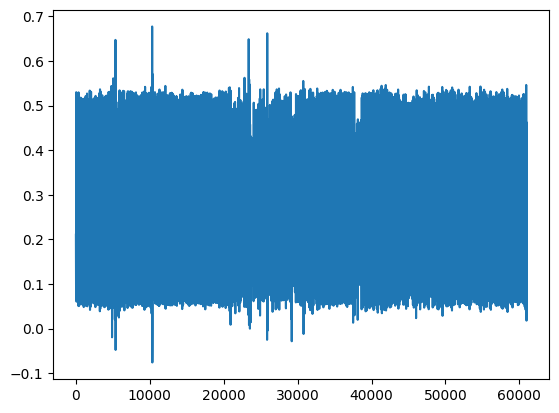

In [178]:
plt.plot(wd['hr'])
print(wd['peaklist'])
valid_peak_locs = np.array(wd['peaklist'])[wd['binary_peaklist']==1]
a = wd['hr'][valid_peak_locs]
a.shape,len(wd['peaklist']),valid_peak_locs

In [201]:
valid_peak_locs = np.array(wd['peaklist'])[wd['binary_peaklist']==1]
a = wd['hr'][valid_peak_locs]
a.shape,len(wd['peaklist']),valid_peak_locs
k = 11
v,i = hampel(a,k=k)
# print(a)
i,np.where(i)[0],len(i),len(np.where(i)[0])

(990,)


(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

((array([ 76,  82,  86,  87,  88,  89, 152, 162, 163, 164, 165, 166, 167,
         168, 341, 370, 372, 378, 379, 380, 381, 384, 385, 386, 387, 411,
         419, 421, 422, 423, 424, 429, 475, 500, 503, 512, 519, 612, 613,
         616, 618, 619, 620, 622, 623, 624, 641, 778, 779, 780, 783, 809],
        dtype=int64),),
 6)

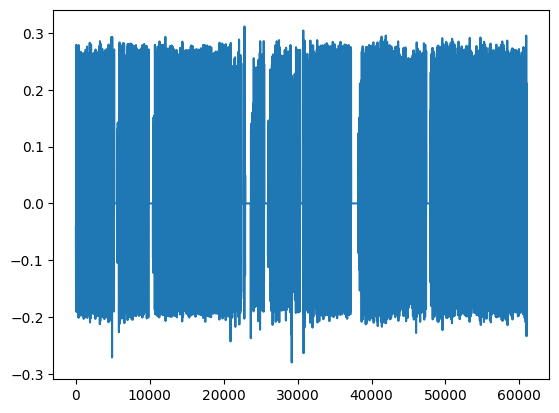

In [202]:
sig3 = sig2.copy()
offset = (k-1//2)
loc = valid_peak_locs[np.where(i)[0]]
for l in loc:
    sig3[l-100-offset:l+100-offset]=0
# plt.plot(sig2,color='orange')
plt.plot(sig3)
np.where(i),len(np.where((sig3>0.3))[0])

(4,) (61000,)


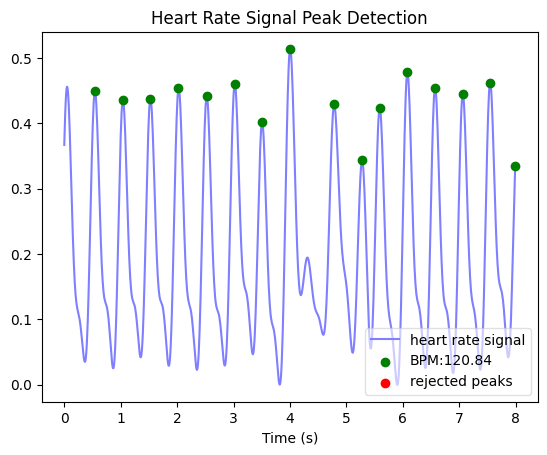

In [198]:
a = np.where((sig3>0.3))[0]
print(a.shape,sig3.shape)
i = np.random.randint(len(a))
hp.plotter(*hp.process(sig2[a[i]-500:a[i]+500],sample_rate=125.0))

(991,)


(58, 0)

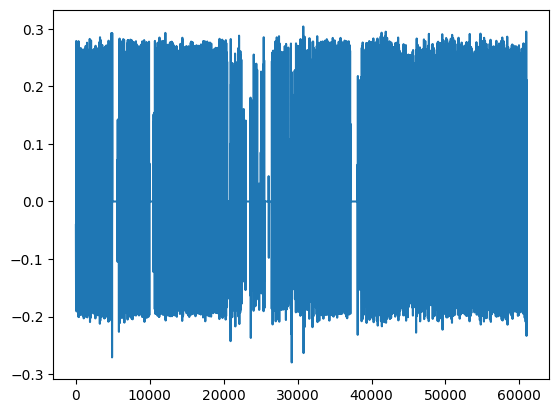

In [221]:
wd,m=hp.process(-sig2,sample_rate=125.0)
valid_peak_locs = np.array(wd['peaklist'])[wd['binary_peaklist']==1]
a = wd['hr'][valid_peak_locs]
k = 9
v,i = hampel(a,k=k)
sig3 = sig2.copy()
offset = (k-1//2)
loc = valid_peak_locs[np.where(i)[0]]
for l in loc:
    sig3[l-100-offset:l+100-offset]=0
# plt.plot(sig2,color='orange')
plt.plot(sig3)
len(np.where(i)[0]),len(np.where((-sig3>0.3))[0])

(51,) (61000,)


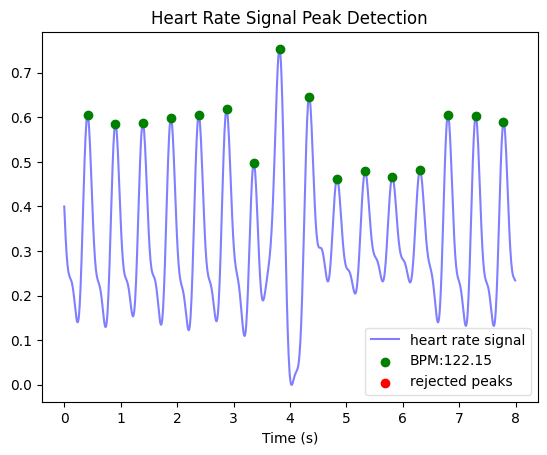

In [214]:
a = np.where((-sig3>0.25))[0]
print(a.shape,sig3.shape)
i = np.random.randint(len(a))
hp.plotter(*hp.process(sig2[a[i]-500:a[i]+500],sample_rate=125.0))

In [23]:
a = np.load(r"..\data\processed\BP_npy\0122\p00\validate.npy")
# a = np.load(r"..\data\processed\BP_npy\1121\p00\p000000.npy")

In [16]:
a.shape

(124694, 256, 2)

6062


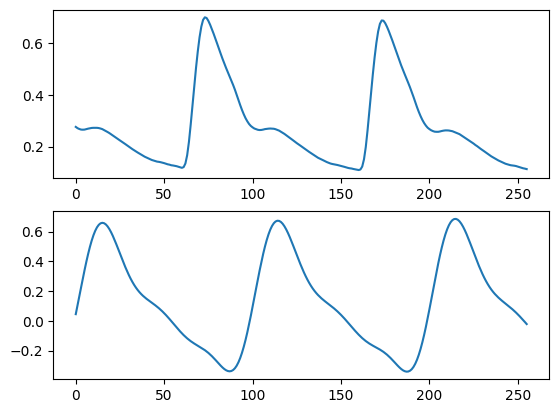

In [51]:
i = np.random.randint(94778)
print(i)
plt.subplot(211)
plt.plot(a[i,:,0])
plt.subplot(212)
plt.plot(a[i,:,1])